In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import palettable

import sys
sys.path.append('..')
import lib as mlib
from lib import *

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('../custom.mplstyle')

In [2]:
phenotype = 'PBMC'
meta = pd.read_csv(data_directory + 'metadata-chu.csv', parse_dates=['date'])
subjects = meta['subject'].unique()
dfms = {}
times = {}
for subject in meta['subject'].unique():
    time, dfm = load_chu(subject, phenotype, rank=True)
    dfms[subject] = dfm
    times[subject] = time

In [3]:
def stats(time, dfm, mean_estimator=np.mean, variance_estimator=np.var,
          mask_function=None,
          translationinvariant=True):
    """Calculate statistics
    
    translationinvariant: if True compare accross all dt
    """
    num_timepoints = len(time)
    indices = np.argsort(time)
    
    if mask_function is None:
        mask_function = lambda f0, f1 : (0.5*(f0+f1) > 1e-4) & (f0 > 1e-6) & (f1 > 1e-6)
    
    dts = []
    means = []
    variances = []
    for i in range(num_timepoints) if translationinvariant else [1]:
        f0 = dfm['freqs_'+str(indices[i])]
        r0 = dfm['rank_'+str(indices[i])]
        for j in range(i+1,num_timepoints):
            f1 = dfm['freqs_'+str(indices[j])]
            r1 = dfm['rank_'+str(indices[j])]
            dts.append(time[j]-time[i])
            mask = mask_function(f0, f1, r0, r1)
            data = np.log(f1[mask]/f0[mask])
            mean = mean_estimator(data)
            variance = variance_estimator(data)
            means.append(mean)
            variances.append(variance)
    dts = np.array(dts)
    means = np.array(means)
    variances = np.array(variances)
    return dts, means, variances

In [4]:
def fit_regression(xs, ys, **kwargs):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(xs, ys)
    kwargs['label'] = kwargs.pop('label', '') #+ ': ${0:.2f} \pm {1:.2f}$'.format(slope, stderr)
    sns.regplot(xs, ys, **kwargs)
    return '${0:.2f} \pm {1:.2f}$'.format(slope, np.ceil(stderr*100)/100)

def shufflingtest(xs, ys, Nshuffle=10000, test='larger'):
    slope, intercept = np.polyfit(xs, ys, 1)
    slopes = []
    intercepts = []
    for i in range(Nshuffle):
        slope_shuffled, intercept_shuffled = np.polyfit(np.random.permutation(xs), ys, 1)
        slopes.append(slope_shuffled)
        intercepts.append(intercept_shuffled)
    slopes = np.sort(np.array(slopes))
    if test == 'larger':
        p = 1-np.searchsorted(slopes, slope)/Nshuffle
        print(slope, np.percentile(slopes, 95), p)
    if test == 'smaller':
        p = np.searchsorted(slopes, slope)/Nshuffle
        print(slope, np.percentile(slopes, 5), p)
    return p

-0.5485816223272343 -0.5017224552453917 0.0253
0.11164377331535491 0.11143909085087178 0.048900000000000055
-0.017106764093130562 -0.013887024810547653 0.016
-0.4166799536857357 -0.6112837184565209 0.147
0.05248981941990177 0.29985843642761323 0.29100000000000004
-0.03524100427722297 -0.0337227673481969 0.0374
-0.11443312057575951 -0.11443312057575951 0.0494
0.15565753450079023 0.13177117159374674 0.0047000000000000375
-0.024535741916093225 -0.03160025690156533 0.1285


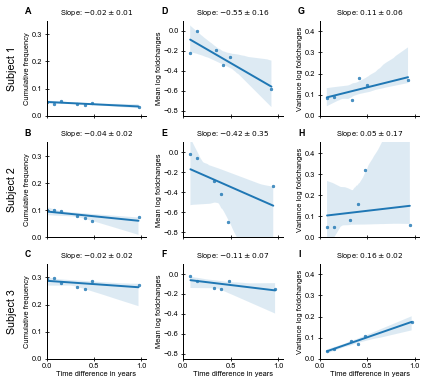

In [5]:
mean_estimator, variance_estimator, mask_function =    (
        np.mean,
        np.var,
        lambda f0, f1, r0, r1: (r0<250) & (~f1.isna())
        )

dtss = []
variancess = []
meanss = []

fig, axes_arr = plt.subplots(sharex=True, ncols=3, nrows=3, figsize=(3*2.0, 3*1.8))

for row, subject in enumerate(subjects):
    axes = axes_arr[row]

    dfm = dfms[subject]
    dfm = dfm[(dfm['counts_0']>0)]
    dts, means, variances = stats(times[subject], dfm,
                                  mean_estimator=mean_estimator,
                                  variance_estimator=variance_estimator,
                                  mask_function=mask_function,
                                  translationinvariant=False)
    
    ax = axes[1]
    fit = fit_regression(dts, means, label=subject, ax=ax)
    p = shufflingtest(dts, means, test='smaller')
    ax.set_title('Slope: ' + fit,
                 fontsize='small')
    ax.set_ylim(-0.85, 0.1)
    ax.set_ylabel('Mean log foldchanges')
    
    ax = axes[2]
    fit = fit_regression(dts, variances, label=subject, ax=ax)
    p = shufflingtest(dts, variances, test='larger')
    ax.set_title('Slope: ' + fit,
                 fontsize='small')
    ax.set_ylim(0.0, 0.45)
    ax.set_ylim(0.0)
    ax.set_ylabel('Variance log foldchanges')
    

    ax = axes[0]
    cumfreqs = dfm[dfm['rank_1']<250].sum().filter(like='freqs')
    x, y = time[1:]-time[1], cumfreqs[1:]
    fit = fit_regression(x, y, label=subject, ax=ax)
    p = shufflingtest(x, y, test='smaller')
    ax.set_title('Slope: ' + fit,
                 fontsize='small')
    ax.set_yscale('linear')
    ax.set_ylim(0.0, 0.35)
    ax.set_ylabel('Cumulative frequency')

pad = 5.0
for ax, subject in zip(axes_arr[:,0], subjects):
    ax.annotate('Subject %g'%subject, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

for ax in axes_arr.flatten():
    ax.set_xlim(0.0, 1.05)
for ax in axes_arr[-1, :]:
    ax.set_xlabel('Time difference in years')

label_axes(axes_arr.flatten(order='F'), xy=(-0.22, 1.05), va='bottom')

fig.tight_layout()
fig.savefig(figure_directory+'mean_variance_fitting_all.svg')

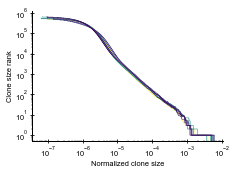

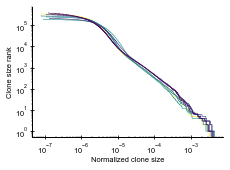

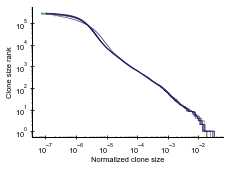

In [6]:
cmap = plt.cm.get_cmap("viridis")
for subject, dfm in dfms.items():
    plt.figure()
    ts = times[subject]
    norm = matplotlib.colors.Normalize(vmin=min(ts), vmax=max(ts))
    for i in range(0, 8)[::-1]:
        l, = plot_rankfrequency(dfm['counts_%g'%i], label=subject,
                                alpha=1.0, lw=0.6,
                                color=cmap(norm(ts[i])))

$2 \cdot 0.08\,(\pm 0.01)\, t$
$ + 0.02\,(\pm 0.01)$


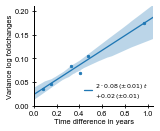

In [7]:
mean_estimator, variance_estimator, mask_function =    (
        np.mean,
        np.var,
        lambda f0, f1, r0, r1: (r0<250) & (~f1.isna())
        )

dtss = []
variancess = []
meanss = []
subject = 3

fig, ax = plt.subplots(sharex=True, figsize=(2.3, 1.9))

dfm = dfms[subject]
dfm = dfm[(dfm['counts_0']>0)]
dts, means, variances = stats(times[subject], dfm,
                              mean_estimator=mean_estimator,
                              variance_estimator=variance_estimator,
                              mask_function=mask_function,
                              translationinvariant=False)

plot_regression(dts, variances, fit_slope=False, extend=0.1, fittype='statsmodels',
                fittransform=lambda x: x*2, 
                label='$2 \cdot {0:.2f}\,(\pm {2:.2f})\, t$\n$ + {1:.2f}\,(\pm {3:.2f})$')

ax.legend(loc='lower right')
ax.set_ylim(0.0, 0.21)
ax.set_xlim(0.0, 1.05)
ax.set_xticks(np.arange(0.0, 1.1, 0.2))
ax.set_xlabel('Time difference in years')
ax.set_ylim(0.0)
ax.set_ylabel('Variance log foldchanges')
fig.tight_layout()
fig.savefig(figure_directory+'chu_mean_variance_fitting.svg')